**Especialización en analítica y ciencia de datos**.


**Monografía - Entrega #4**

**Grupo 11**

Autores: Jorge Luis Genes Padilla - John Byron Alzate Hernández

**Codigo utilizado para los análisis:**

In [ ]:
# Importación de librerias necesarias para los diferentes análisis:

# Tratamiento de datos
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
import warnings

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, auc, roc_curve, precision_score,
                             recall_score, r2_score, mean_squared_error, mean_absolute_error,
                             roc_auc_score, median_absolute_error, accuracy_score)
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot')

# Configuración warnings
warnings.filterwarnings('ignore')



In [ ]:
# Lectura del archivo CSV que contiene la información original en estado base:
df = pd.read_csv('bd_entrega_4.csv', delimiter=';')

In [ ]:
# Conversión la columna "FECHANTO" a formato de fecha y calcular la edad
df['EDAD'] = pd.Timestamp.today().year - pd.to_datetime(df.pop('FECHANTO'), format='%d/%m/%Y').dt.year

In [ ]:
# Categorizar la columna "EDAD" según los nuevos rangos y categorías proporcionadas
bins = [-np.inf, 17, 29, 49, 69, np.inf]
labels = ["Underage", "Young", "Adult", "Old", "Very old"]
df['AgeCategory'] = pd.cut(df['EDAD'], bins=bins, labels=labels, right=True)

In [ ]:
# Crear una variable 'Puntaje_Categorico' para categorizar la variable de salida 'PUNTAJE'
def categorize_puntaje(score):
    if 0 <= score <= 40:
        return "Bajo"
    else:
        return "Alto"

df['Puntaje_Categorico'] = df['PUNTAJE'].apply(categorize_puntaje)

In [ ]:
# Eliminar la columna 'Puntaje' y eliminar registros duplicados.
df.drop('PUNTAJE', axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
# Ver los resultados de las operaciones hasta el momento
df

,COMUNA,TELEFONO,VIVIENDA,PARED,PISO,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,...,EMBARAZA,ASISTE,TIPOESTA,GRADO,NIVEL,INGRESOS,PERCIBE,EDAD,AgeCategory,Puntaje_Categorico
0,1,1,1,2,3,1,1,2,1,1,...,1,2,0,3,1,0,1,71,Very old,Bajo
1,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,2,92,Very old,Bajo
2,1,1,1,2,3,1,1,2,1,1,...,1,2,0,5,1,0,2,86,Very old,Bajo
3,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,1,54,Old,Bajo
4,1,1,1,2,3,1,1,2,1,1,...,2,2,0,5,1,0,2,43,Adult,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048530,7,2,1,1,2,1,1,2,1,1,...,2,1,4,1,1,0,2,15,Underage,Bajo
1048531,7,1,1,1,2,1,1,1,1,1,...,2,2,0,0,0,100000,1,92,Very old,Bajo
1048532,7,1,1,1,2,1,1,1,1,1,...,1,2,0,3,1,0,2,67,Old,Bajo
1048533,7,1,1,1,2,1,1,1,1,1,...,2,2,0,0,0,0,2,9,Underage,Bajo


In [ ]:
# Obtener y ver un resumen numérico estadistico de los datos
df.describe()

,COMUNA,TELEFONO,VIVIENDA,PARED,PISO,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,...,DISCAPA,CARNET,EMBARAZA,ASISTE,TIPOESTA,GRADO,NIVEL,INGRESOS,PERCIBE,EDAD
count,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,...,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06,1.033452e+06
mean,3.988210e+00,1.212070e+00,1.032379e+00,1.252123e+00,2.439165e+00,1.000569e+00,1.047880e+00,1.491647e+00,1.001011e+00,1.008899e+00,...,1.099848e-01,2.295249e+00,1.707565e+00,1.708284e+00,1.074464e+00,3.238634e+00,1.419800e+00,1.447396e+05,1.605013e+00,4.031414e+01
std,2.006360e+00,4.087742e-01,1.770534e-01,7.914598e-01,5.816255e-01,2.384625e-02,2.135131e-01,4.999305e-01,3.178290e-02,9.391545e-02,...,7.958502e-01,1.659756e+00,4.548815e-01,4.545523e-01,1.760193e+00,2.210197e+00,9.353699e-01,2.734398e+05,4.888481e-01,2.016044e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00
25%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.500000e+01
50%,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,3.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.700000e+01
75%,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00,2.000000e+00,2.000000e+05,2.000000e+00,5.500000e+01
max,7.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00,6.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,7.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,8.000000e+00,6.000000e+00,5.000000e+00,1.500000e+07,2.000000e+00,1.210000e+02


In [ ]:
# Lista de columnas a convertir a tipo 'object'
columns_to_object = ['COMUNA', 'TELEFONO', 'VIVIENDA', 'PARED', 'PISO', 'ENERGIA', 'ALCANTA',
                      'GAS', 'BASURA', 'ACUEDUC', 'ESTRATO', 'ELIMBASURA', 'THOGAR', 'TENEVIV', 'USOSANI', 'USANITAR', 'DUCHA',
                      'AGUA', 'LLEGA', 'SUMINIS', 'PREPARAN', 'COCINA', 'COCINAN', 'ALUMBRA', 'USOTELE', 'NEVERA', 'LAVADORA', 'TVCOLOR', 'TVCABLE',
                      'CALENTA', 'HORNO', 'AIRE', 'COMPUTADOR', 'MOTO', 'AUTO1', 'SEXO', 'PARENTES', 'ESTCIVIL', 'CONYUVIVE', 'DISCAPA', 'CARNET', 'EMBARAZA',
                      'ASISTE', 'TIPOESTA', 'GRADO', 'NIVEL', 'PERCIBE','AgeCategory','Puntaje_Categorico']

# Cambiar las columnas a formato 'object'
df[columns_to_object] = df[columns_to_object].astype('object')


In [ ]:
# Revisar el tipo de datos que existen hasta este paso en el dataframe.
df.dtypes

COMUNA                object
TELEFONO              object
VIVIENDA              object
PARED                 object
PISO                  object
ENERGIA               object
ALCANTA               object
GAS                   object
BASURA                object
ACUEDUC               object
ESTRATO               object
ELIMBASURA            object
THOGAR                object
TENEVIV               object
USOSANI               object
USANITAR              object
DUCHA                 object
AGUA                  object
LLEGA                 object
SUMINIS               object
PREPARAN              object
COCINA                object
COCINAN               object
ALUMBRA               object
USOTELE               object
NEVERA                object
LAVADORA              object
TVCOLOR               object
TVCABLE               object
CALENTA               object
HORNO                 object
AIRE                  object
COMPUTADOR            object
MOTO                  object
AUTO1         

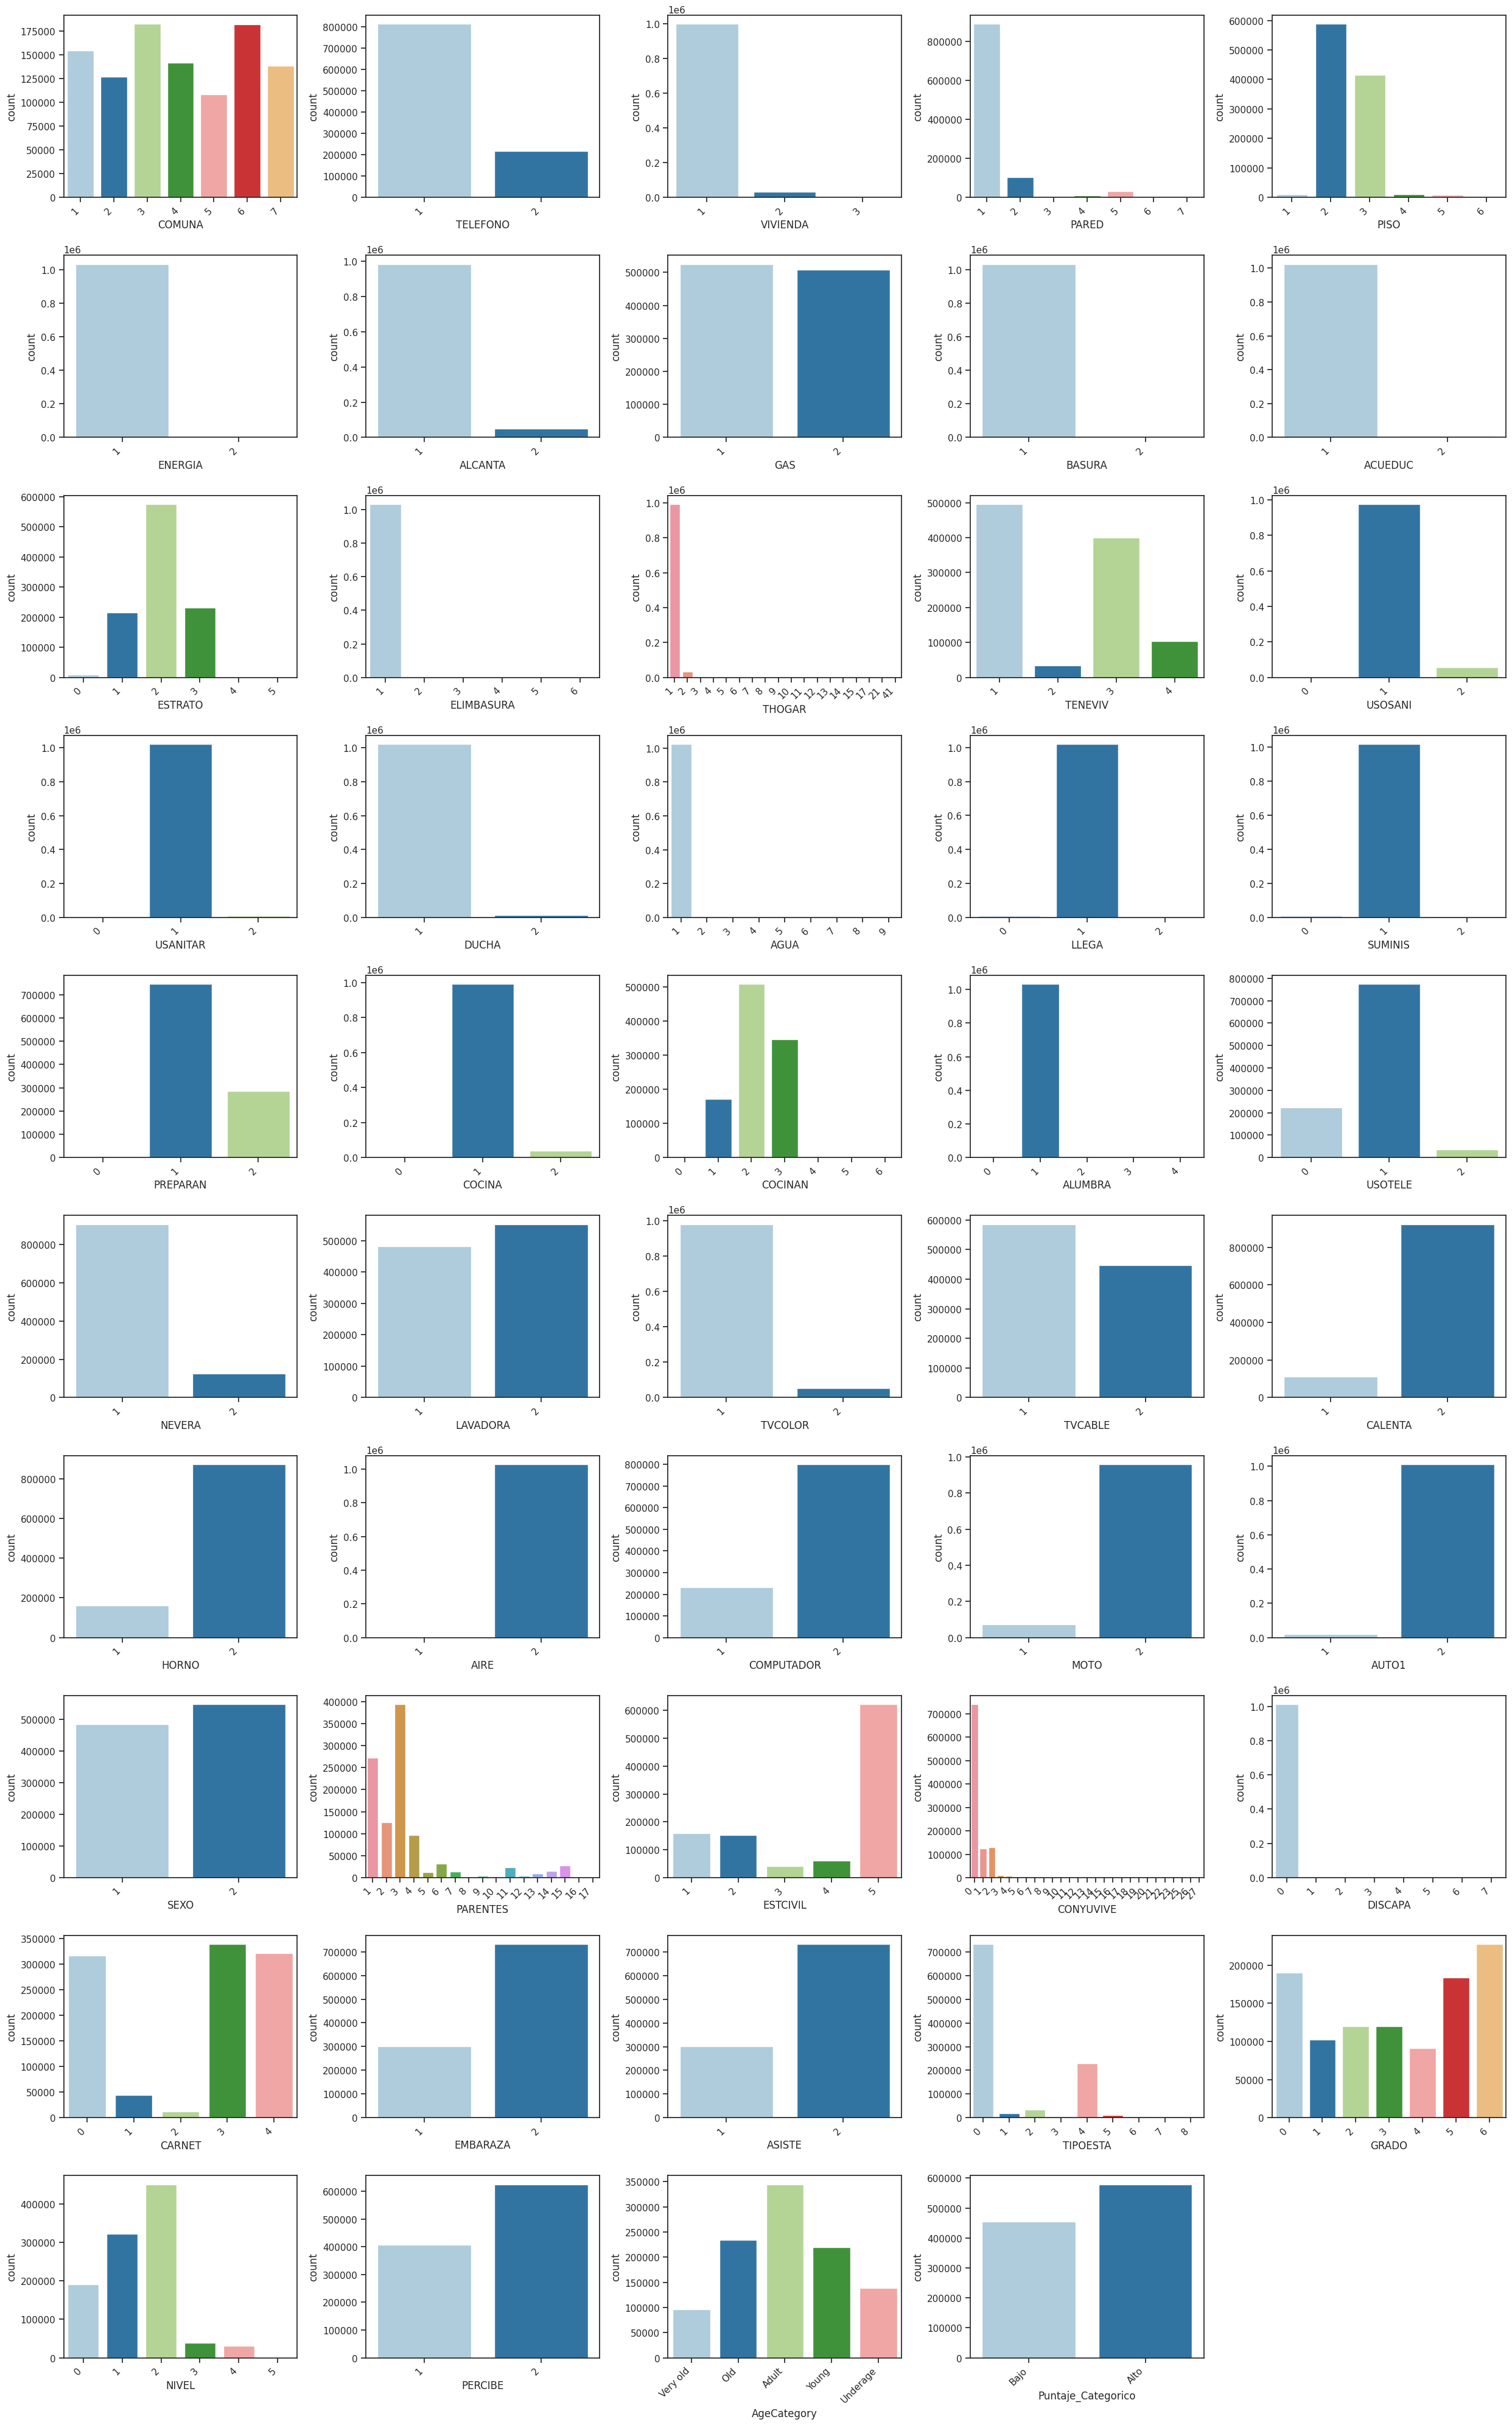

In [ ]:
# Establecer las variables categóricas con la caracteristica tipo objeto
categorical_features = df.select_dtypes(include=[object])

# Establecer estilos de Seaborn
sns.set(palette='Paired', style="ticks")

# Determinar el número de filas y columnas para subgráficos
n_features = len(categorical_features.columns)
n_cols = 5
n_rows = math.ceil(n_features / n_cols)

# Realizar los gráficos de las variables categóricas
plt.figure(figsize=(25, 40), tight_layout=True)
for i, feature in enumerate(categorical_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=feature, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

In [ ]:
# Definición para convertir columna 'INGRESOS' a tipo 'float64'
columns_to_number = ['INGRESOS']
df[columns_to_number] = df[columns_to_number].astype('float64')


In [ ]:
# Revisar el tipo de datos que existen hasta este paso en el dataframe.
df.dtypes

COMUNA                 object
TELEFONO               object
VIVIENDA               object
PARED                  object
PISO                   object
ENERGIA                object
ALCANTA                object
GAS                    object
BASURA                 object
ACUEDUC                object
ESTRATO                object
ELIMBASURA             object
THOGAR                 object
TENEVIV                object
USOSANI                object
USANITAR               object
DUCHA                  object
AGUA                   object
LLEGA                  object
SUMINIS                object
PREPARAN               object
COCINA                 object
COCINAN                object
ALUMBRA                object
USOTELE                object
NEVERA                 object
LAVADORA               object
TVCOLOR                object
TVCABLE                object
CALENTA                object
HORNO                  object
AIRE                   object
COMPUTADOR             object
MOTO      

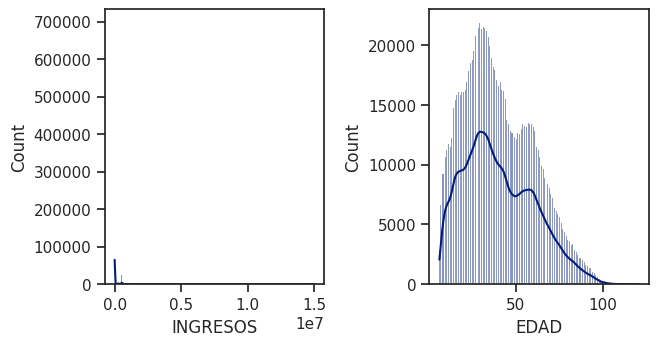

In [ ]:
# Establecer las variables numéricas del dataset
numeric_features = df.select_dtypes(include=[np.number])

# Establecer estilos de Seaborn
sns.set(palette='dark', style="ticks")

# Configurar el número de filas y columnas para subgráficos en 2x2
n_cols = 3
n_rows = 3

# Graficar las variables numéricas del dataset
plt.figure(figsize=(10, 10), tight_layout=True)  # Ajustar el tamaño de la figura
for i, feature in enumerate(numeric_features.columns, 1):
    if i > 5:  # Solo mostrar 4 gráficas
        break
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel("Count")

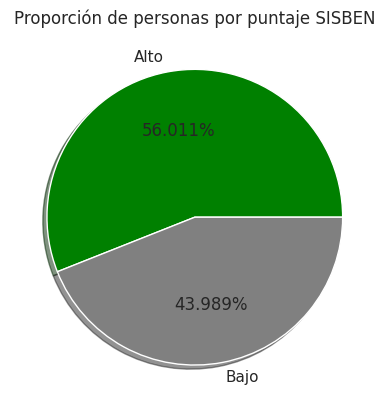

In [ ]:
# Realizar el conteo del número de registros de la variable 'Puntaje_Categorico' y graficarlos en una gráfica de torta.
plt.pie(x = df['Puntaje_Categorico'].value_counts() ,autopct='%1.3f%%' ,labels=['Alto', 'Bajo'], colors=['green', 'gray'], shadow=True)
plt.title('Proporción de personas por puntaje SISBEN')
plt.show()


In [ ]:
# Disminuir el número de registros del dataset a una muestra aleatoria de 100000 (Cien mil) registros
semilla_aleatoria = 42  # Puedes usar cualquier número entero como semilla

df = df.sample(n=100000, random_state=semilla_aleatoria)


In [ ]:
# Hacer llamado a la funcionalidad de Label encoder para clasificación categórica
le = LabelEncoder()

# Obtener una lista de nombres de columnas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Generar variables dummies de las columnas categoricas
for col in categorical_cols:
    if len(df[col].unique()) <= 2:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [ ]:
# Ver el resultado final de las transformaciones del dataset
df.head()

,TELEFONO,ENERGIA,ALCANTA,GAS,BASURA,ACUEDUC,DUCHA,NEVERA,LAVADORA,TVCOLOR,...,GRADO_6,NIVEL_1,NIVEL_2,NIVEL_3,NIVEL_4,NIVEL_5,AgeCategory_Old,AgeCategory_Underage,AgeCategory_Very old,AgeCategory_Young
113276,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
897996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
949009,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
43549,0,0,0,0,0,0,0,1,1,1,...,1,0,1,0,0,0,0,0,0,0
849632,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
# Guardar el DataFrame reducido en un archivo Excel
# nombre_archivo = "bd_entrega_4_archivo_salida.csv"  # Puedes cambiar el nombre del archivo según tus necesidades
# df.to_csv(nombre_archivo, index=False)  # index=False para no incluir el índice del DataFrame en el archivo

In [ ]:
# Separar las características y la variable objetivo
X = df.drop(columns='Puntaje_Categorico')
y = df['Puntaje_Categorico']


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% para prueba, división reproducible

# Realizar escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**RandomForest:**

In [ ]:
# Crear una instancia del clasificador de bosque aleatorio
rf_classifier = RandomForestClassifier(random_state=42) # random_state=42 asegura resultados reproducibles

In [ ]:
# Entrenar el clasificador de bosque aleatorio con los datos escalados
rf_classifier.fit(X_train_scaled, y_train) # X_train_scaled: datos de entrada escalados, y_train: etiquetas de entrenamiento

# Hacer predicciones sobre los datos de prueba
y_pred = rf_classifier.predict(X_test_scaled)

# Calcular la precisión de entrenamiento del clasificador
tr_accuracy = rf_classifier.score(X_train_scaled, y_train)

# Calcular la precisión del clasificador
ts_accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", f'{round(tr_accuracy, 4) * 100}%')
print("Test Accuracy:", f'{round(ts_accuracy, 4) * 100}%')

Train Accuracy: 99.97%
Test Accuracy: 77.96%


Confusion Matrix:


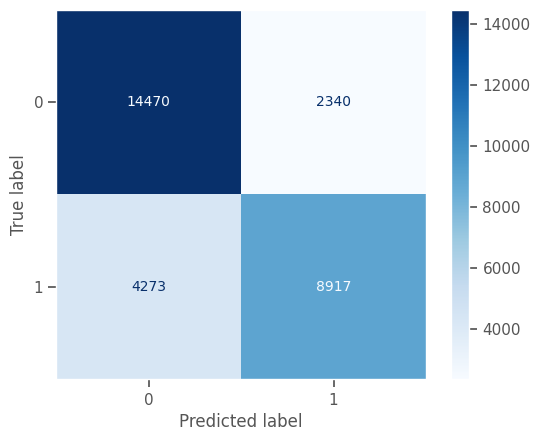

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81     16810
           1       0.79      0.68      0.73     13190

    accuracy                           0.78     30000
   macro avg       0.78      0.77      0.77     30000
weighted avg       0.78      0.78      0.78     30000



In [ ]:
# Suponiendo que y_test y y_pred ya están definidos
c_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con números enteros y colores suaves
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=rf_classifier.classes_)
cm_display.plot(values_format='d', cmap='Blues')  # 'd' para formato de número entero, 'Blues' para el mapa de colores
print("Confusion Matrix:")
plt.grid(False)  # Desactiva la cuadrícula para una visualización más clara
plt.show()

# Mostrar el informe de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

**Nota:** En la matriz anterior, 0 y 1 son los valores de la variable Puntaje Categorico, los cuales se refieren a rangos de puntaje numerico.

El modelo de clasificación demuestra un rendimiento equilibrado y eficaz en términos de precisión, recall y puntuación F1. La precisión general (accuracy) del modelo es del 78%, lo que indica que es capaz de clasificar correctamente aproximadamente 78 de cada 100 instancias.

**En términos de clases individuales:**

**Clase 0 (Primera Clase):**

Precisión: 77%, lo que significa que el 77% de las instancias predichas como clase 0 son correctas.
Recall: 86%, lo que indica que el modelo pudo identificar correctamente el 86% de todas las instancias reales de la clase 0.
Puntuación F1: 0.81, reflejando un buen equilibrio entre precisión y recall para esta clase.

**Clase 1 (Segunda Clase):**

Precisión: 79%, un poco más alta que la clase 0, lo que sugiere una mayor eficacia en la predicción correcta de esta clase.
Recall: 68%, sugiere que el modelo tiene dificultades para identificar correctamente todos los casos reales de la clase 1.
Puntuación F1: 0.73, que es más baja que la de la clase 0, lo cual se debe principalmente al menor recall.
Las puntuaciones promedio macro y ponderadas son coherentes con un rendimiento general equilibrado del modelo. Sin embargo, se observa que el modelo tiende a ser mejor en la identificación de instancias de la clase 0 (mayor recall), pero tiene una precisión ligeramente superior en la clase 1. Esta información es útil para identificar áreas donde se podría mejorar el modelo, como aumentar el recall para la clase 1

**Regresión Logística:**

In [ ]:
# Crear una instancia de Regresión Logística con validación cruzada
lr = LogisticRegressionCV(solver='lbfgs') # 'lbfgs' es el algoritmo de optimización

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% de datos para prueba, división reproducible


# Realizar escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Entrenar el modelo de regresión logística con los datos escalados
lr.fit(X_train_scaled, y_train) # X_train_scaled: datos de entrada escalados, y_train: etiquetas de entrenamiento

# Predecir las etiquetas para el conjunto de prueba escalado
y_pred = lr.predict(X_test_scaled) # X_test_scaled: datos de prueba escalados

# Calculate the train accuracy of the classifier
tr_accuracy = lr.score(X_train_scaled, y_train)

# Calculate the accuracy of the classifier
ts_accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", f'{round(tr_accuracy, 4) * 100}%')
print("Test Accuracy:", f'{round(ts_accuracy, 4) * 100}%')

Train Accuracy: 78.71000000000001%
Test Accuracy: 78.36999999999999%


Confusion Matrix:


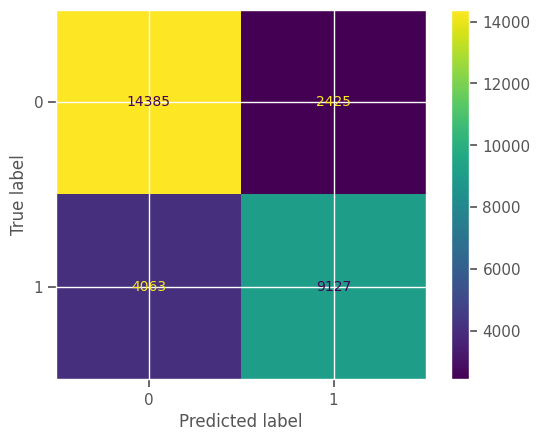

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82     16810
           1       0.79      0.69      0.74     13190

    accuracy                           0.78     30000
   macro avg       0.78      0.77      0.78     30000
weighted avg       0.78      0.78      0.78     30000



In [ ]:
# Crear la matriz de confusión comparando las etiquetas reales (y_test) y las predicciones (y_pred)
c_matrix = confusion_matrix(y_test, y_pred)

# Crear un objeto de visualización para la matriz de confusión usando la matriz calculada
# Se corrige 'metrics.ConfusionMatrixDisplay' a 'ConfusionMatrixDisplay' para evitar errores
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix)

# Dibujar y mostrar la matriz de confusión
cm_display.plot()
print("Confusion Matrix:")
plt.show()  # Muestra la matriz de confusión en una ventana gráfica

# Generar y mostrar el informe de clasificación, proporcionando detalles como precisión, recall, f1-score para cada clase
print("Classification Report:\n", classification_report(y_test, y_pred))


**Nota:** En la matriz anterior, 0 y 1 son los valores de la variable Puntaje Categorico, los cuales se refieren a rangos de puntaje numerico.

El modelo de clasificación evaluado muestra un rendimiento generalmente bueno, con una precisión, recall (sensibilidad) y puntuación F1 equilibrados en ambas clases (0 y 1). La precisión general (accuracy) del modelo es del 78%, lo que indica que en general, el modelo es capaz de clasificar correctamente las etiquetas en aproximadamente 78 de cada 100 casos.

**En detalle:**

**Clase 0 (Primera Clase):**

La precisión es del 78%, lo que significa que de todas las instancias que el modelo predijo como clase 0, el 78% eran correctas.
El recall es del 86%, indicando que el modelo pudo identificar correctamente el 86% de todas las instancias reales de la clase 0.
La puntuación F1 de 0.82 sugiere un buen equilibrio entre precisión y recall para esta clase.

**Clase 1 (Segunda Clase):**

La precisión es ligeramente más alta para esta clase (79%), lo que indica una eficacia ligeramente mejor en la predicción correcta de esta clase en comparación con la clase 0.
Sin embargo, el recall es más bajo (69%), lo que sugiere que el modelo tiene más dificultades para identificar correctamente todos los casos reales de la clase 1.
La puntuación F1 de 0.74 es más baja que la de la clase 0, reflejando el menor recall.
En resumen, el modelo muestra una ligera preferencia en términos de rendimiento para la clase 0, con un mejor recall pero una precisión ligeramente menor. La clase 1, aunque es predicha con mayor precisión, es más a menudo pasada por alto por el modelo, como lo indica un recall más bajo. La evaluación global del modelo es equilibrada, como se refleja en las puntuaciones promedio macro y ponderadas. Estos resultados podrían guiar los esfuerzos para ajustar y mejorar el modelo, especialmente en términos de mejorar el recall para la clase 1 sin sacrificar la precisión.